# Learn Linear Regression by Implementing in NumPy
> Explaination of linear regression by implementing it in Python NumPy.

- toc: false 
- badges: true
- comments: true
- author: Adam Orucu
- categories: [machine learning, numpy]
- image: images/cover/linear-regression.png

Following the principle:
> The best way to learn is by doing.

In this post we will learn how linear regression works and implement it at the same time. This is the first post of a series so if you end up learning something usefull don't stop and continue with the next ones. The whole post is a _Jupyter Notebook_ and was created using `Fast Pages` so if you'd like to replicate the steps you can do so by using the above links for several different methods.

In [4]:
#hide
!pip3 install numpy pandas matplotlib seaborn sklearn

  Using cached seaborn-0.11.0-py3-none-any.whl (283 kB)
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1315 sha256=cde406bd7c10f7f3c76bddea3546d6651f4bf293eab80c1cb8ea53d9452ef7a8
  Stored in directory: /home/adam/.cache/pip/wheels/22/0b/40/fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn


In [16]:
#collapse-hide
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Code
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from sklearn import datasets
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## About the data

Data that we will be using to train and test the model is the [Boston Housing Dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html). This dataset contains information on housing in the city of Boston and we will use it to try to predict value of some owner-occupied homes.

In [226]:
#collapse-hide
X, y = datasets.load_boston(return_X_y=True)
X = pd.DataFrame(data=X, columns=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'])
X_train, X_test, y_train, y_test = train_test_split(X['AGE'].to_numpy().reshape(-1, 1), y, test_size=0.33, random_state=42)

The data can be viewed below. Here every column represents an attribute of the data, like age, crime, or patio-ratio. Although for this project only one attribute will be uses to ease the visualisation - namely **age** of the property.

In [228]:
#collapse-hide
temp = X; temp['target'] = y; temp.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## Our Goal
As stated our goal is to predict values of given houses to be as close to the real value as possible. Below an example can be viewed, which was created using scikit-learn the table presents predicted and true values for 5 housing units. We will be creating a similar model on our own.

In [19]:
from sklearn.linear_model import LinearRegression as skLinReg
clf = skLinReg().fit(X_train, y_train, )
pd.DataFrame(data=[clf.predict(X_test)[:5], y_test[:5]], index=['Prediction', 'True'])

,0,1,2,3,4
Prediction,21.133509,27.338643,19.351957,30.380613,20.200315
True,23.600000,32.400000,13.600000,22.800000,16.100000


## Let's Get to It

Although the linear regression model is fairly simple to understand while making predictions, there is some math involved in the process of training the model. So without further ado, let's begin.

---

Prediction making in linear regression can be basically stated as drawing a line through the available data so that it represents the data as accurately as possible. We do that ofcourse by creating an equation that represents a line, e.g. $3x + 4 = y$. This equation says that if our input data point is a $2$ the prediction made will be $10$. The input data can of course have more then one attribute for a single data point. In such a case the equation can be written as follows; $\theta_1 * x_1 + \theta_2 * x_2 + \theta_0 = y$. Theta, being the weight of each attribute.

Since we will not get only one data point but much more, it will be usefull to represent it with a matrix, where each column of $X$ is an attribute, each row a seperate data point that is available to us. Thetas and the output y can represented as two vectors in such a case. This will result in the below equation.
$$X \cdot \theta = y$$
Pretty simple formula right? So, let's code it.

In [20]:
#hide_input
Code('''
def predict(self, X, add_intercept=True):
    if add_intercept:
        X = np.column_stack((np.ones((X.shape[0], 1), dtype=X.dtype), X))
    return X @ self.Theta
''', language='py')

def predict(self, X, add_intercept=True):
    if add_intercept:
        X = np.column_stack((np.ones((X.shape[0], 1), dtype=X.dtype), X))
    return X @ self.Theta

Above is the code-snippet that does exactly what we have said so far. Returns an array of predictions by multiplying each row (data point) with theta (weight). You may have realised the two extra lines here. They add to our matrix a column of 1s which are called the intercept they will help us add the $\theta_0$ weight.

---

Now since we now how to make predictions once we have our thetas defined let's learn how we actually choose the thetas that best fir our data. We will see how this can be done, using two different methods. Let's start with **gradient descent**. The general idea here is that; we calculate the error our model is making at step by step try to minimize it.

That said let's define our error (loss) function. Since we try to draw a line so that the distance to the data points is as small as possible, our function will do just that; calculate the average distance to the data points. Instead of getting the absoloute value of the distances we will sqaure it. This is done so the values that are a little off will not affect the model very much, but values that will end up being very far away from the line that we drew increase the error even more.
$$\frac{\sum_{i=0}^n( X_i \cdot \theta - y)}{2n}$$
You probably see an extra 2 in the denominator, it is just to help us in further calculation, you shouldn't worry about it very much.

In [231]:
#hide_input
Code('''
def fit(self, X, y, lamb=0, add_intercept=True, iters=20, lr=1e-6):
    """Fits the training data using gradient descent"""
    if add_intercept:
        X = np.column_stack((np.ones((X.shape[0], 1), dtype=X.dtype), X))
    self.n, self.p = X.shape
    self.X = X
    self.y = np.reshape(y, (len(y), 1))
    self.Theta = np.random.randn(self.p, 1)
    loss_prime = lambda x, y, theta: (x @ theta - y).T @ x
    loss = lambda x, y, theta: 1/(2*self.n) * np.sum(np.square(X @ theta - y))
    self._gradient_descent(iters=iters, loss_prime=loss_prime, lr=lr, loss=loss)
''', language='py')

def fit(self, X, y, lamb=0, add_intercept=True, iters=20, lr=1e-6):
    """Fits the training data using gradient descent"""
    if add_intercept:
        X = np.column_stack((np.ones((X.shape[0], 1), dtype=X.dtype), X))
    self.n, self.p = X.shape
    self.X = X
    self.y = np.reshape(y, (len(y), 1))
    self.Theta = np.random.randn(self.p, 1)
    loss_prime = lambda x, y, theta: (x @ theta - y).T @ x
    loss = lambda x, y, theta: 1/(2*self.n) * np.sum(np.square(X @ theta - y))
    self._gradient_descent(iters=iters, loss_prime=loss_prime, lr=lr, loss=loss)

Since we now our loss function we can move on to the gradient descent. Since we try to minimize the value of the loss function, we can understand what values of thetas make it smaller by calculating the derivate of the loss function we just defined. We is the following:
$$(X \cdot \theta - y)' \cdot X$$
We can move towards a smaller error by substracting this derivative from the theta that we used to calculate it. And that's the gradient descent algorithm. One addition is that instead of just substracting the derivative we first multiply it by a small number (learning rate) so we don't take too big steps and just little by little go to the right direction.

In [7]:
#hide_input
Code('''
def _gradient_descent(self, iters, loss_prime, lr, loss=None):
    """Gradient descent algorithm"""
    for i in range(iters):
        grad = loss_prime(self.X, self.y, self.Theta)
        self.Theta -= lr * grad.T
        if loss != None:
            self.loss.append(loss(self.X, self.y, self.Theta))
''', language='py')

def gradient_descent(self, X, y, iters, lr):
    X = np.hstack((X, np.ones((X.shape[0], 1), dtype=X.dtype)))
    y = np.reshape(y, (len(y),1))
    for i in range(iters):
        gradient = (X.dot(self.weights) - y).transpose().dot(X)
        self.weights = self.weights - (lr * 1/self.m * gradient.transpose())
        self.loss.append(1/(2*self.m) * np.sum(np.square(X.dot(self.weights) - y)))

That was all! If you'd like to see what we ended up with click the button below. Now we will move on to testing our model.

In [218]:
#collapse-hide
class LinearRegression:
    """Linear regression algorithm"""
    def __init__(self):
        self.loss = []
        
    def fit(self, X, y, lamb=0, add_intercept=True, iters=20, lr=1e-6):
        """Fits the training data using normal equation"""
        if add_intercept:
            X = np.column_stack((np.ones((X.shape[0], 1), dtype=X.dtype), X))
        self.n, self.p = X.shape
        self.X = X
        self.y = np.reshape(y, (len(y), 1))
        self.Theta = np.random.randn(self.p, 1)
        loss_prime = lambda x, y, theta: (x @ theta - y).T @ x
        loss = lambda x, y, theta: 1/(2*self.n) * np.sum(np.square(X @ theta - y))
        self._gradient_descent(iters=iters, loss_prime=loss_prime, lr=lr, loss=loss)

    def predict(self, X, add_intercept=True):
        """Makes predictions on the given data"""
        if add_intercept:
            X = np.column_stack((np.ones((X.shape[0], 1), dtype=X.dtype), X))
        return X @ self.Theta
    
    def _gradient_descent(self, iters, loss_prime, lr, loss=None):
        """Gradient descent algorithm"""
        for i in range(iters):
            grad = loss_prime(self.X, self.y, self.Theta)
            self.Theta -= lr * grad.T
            if loss != None:
                self.loss.append(loss(self.X, self.y, self.Theta))

#### Results
You may have realised that we preset values for learning-rate and the number of iterations for gradient descent they are set to values that work, but I would encourage to play around with them. Anyways if we run our model with those parameters here are the values that we obtain. Maybe not as good as the once obtained by scikit-learn but there still seems to have the correct correlation.

In [233]:
#collapse-hide
LinReg = LinearRegression()
LinReg.fit(X_train, y_train)
print('Thetas we ended up with:\n',LinReg.Theta)
pd.DataFrame(data=[LinReg.predict(X_test)[:5,0], y_test[:5]], index=['Prediction', 'True'])

Thetas we ended up with:
 [[31.32592649]
 [-0.12119402]]


,0,1,2,3,4
Prediction,21.133509,27.338643,19.351957,30.380613,20.200315
True,23.600000,32.400000,13.600000,22.800000,16.100000


##### Comparison
Our error (mean squared error) compared to scikit-learn's.

In [190]:
#collapse-hide
from sklearn.metrics import mean_squared_error
print('Our: ', mean_squared_error(LinReg.predict(X_test), y_test),
      '\nSklearns: ', mean_squared_error(clf.predict(X_test), y_test))

Our:  186.30890066587702 
Sklearns:  64.45241584915276


#### Learning
But the most interesting part is to see how our algorithm learns. Below you can see how our error got smaller with every iteration of the gradient descent algortihm.

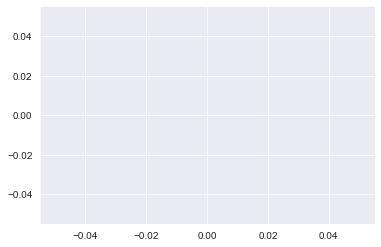

In [234]:
plt.plot(LinReg.loss);plt.show()

And here is the visualisation of the result we obtained and comparison to the result using sklearn.

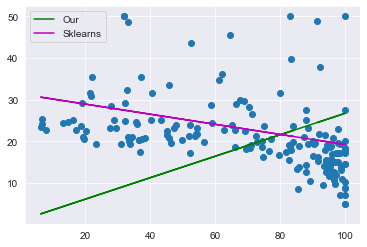

In [201]:
#collapse-hide
LinReg = LinearRegression()
sk = skLinReg()
LinReg.fit(X_train, y_train)
sk.fit(X_train, y_train)

plt.scatter(X_test, y_test)
plt.plot(X_test, LinReg.predict(X_test), 'g')
plt.plot(X_test, sk.predict(X_test), 'm')
plt.legend(['Our', 'Sklearns'])
plt.show()

---

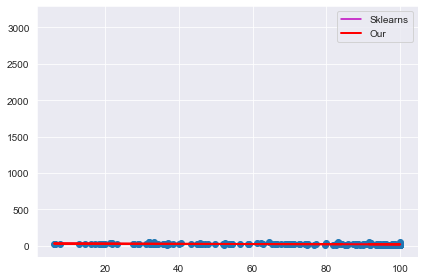

In [236]:
#hide_output
#collapse_hide
from matplotlib import animation
fig, ax = plt.subplots()
fig.set_tight_layout(True)

LinReg2 = LinearRegression()
LinReg2.fit(X_train, y_train, iters=0)
sk = skLinReg()
sk.fit(X_train, y_train)
ax.scatter(X_test, y_test)
ax.plot(X_test, sk.predict(X_test), 'm-')
line, = ax.plot(X_test, np.hstack((X_test, np.ones((X_test.shape[0], 1), dtype=X_test.dtype))).dot(LinReg2.Theta), 'r-', linewidth=2)
ax.legend(('Sklearns', 'Our'))

Writer = animation.writers['pillow']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    LinReg2.fit(X_train, y_train, iters=250)
    line.set_data(X_test, LinReg2.predict(X_test))
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=200, repeat_delay=1000, blit=True)

anim.save('gif/linreg.gif', writer=writer)

![](gif/linreg.gif)

Now, I had said that we will see two algorithm to find values for theta. The first one was gradient descent. The second is called the normal equation. This equation is possible because linear regression is a quite simple idea, so smart people have found a formula that makes the learning process unnecessary and just gives you the correct answer. If you interested in the proof; do go online, I will not do it here. Anyways, here is the equation:
$$(X' \cdot X)^{-1} \cdot X' \cdot y$$
Obviously this equation will not work for every situation. Since you need to invert a matrix you may end up with matricees of data where it is not possible to do so.

In [146]:
C
ode('''
def fit(self, X, y, lamb=0, add_intercept=True, iters=100, lr=3e-8):
    """Fits the training data using normal equation"""
    if add_intercept:
        X = np.column_stack((np.ones((X.shape[0], 1), dtype=X.dtype), X))
    n, p = X.shape
    self.X = X
    self.y = np.reshape(y, (len(y), 1))
    self.Theta = np.linalg.inv(self.X.T @ self.X) @ self.X.T @ self.y
''', language='py')

def fit(self, X, y, lamb=0, add_intercept=True, iters=100, lr=3e-8):
    """Fits the training data using normal equation"""
    if add_intercept:
        X = np.column_stack((np.ones((X.shape[0], 1), dtype=X.dtype), X))
    n, p = X.shape
    self.X = X
    self.y = np.reshape(y, (len(y), 1))
    self.Theta = np.linalg.inv(self.X.T @ self.X) @ self.X.T @ self.y

As you can see using this equation we ended up with the same error, so with the same theta (weight) that scikit-learn has found.

In [229]:
#collapse-hide
class LinearRegression:
    """Linear regression algorithm"""
    def __init__(self):
        self.loss = []
        
    def fit(self, X, y, lamb=0, add_intercept=True, iters=100, lr=3e-8):
        """Fits the training data using normal equation"""
        if add_intercept:
            X = np.column_stack((np.ones((X.shape[0], 1), dtype=X.dtype), X))
        n, p = X.shape
        self.X = X
        self.y = np.reshape(y, (len(y), 1))
        self.Theta = np.linalg.inv(self.X.T @ self.X) @ self.X.T @ self.y

    def predict(self, X, add_intercept=True):
        """Makes predictions on the given data"""
        if add_intercept:
            X = np.column_stack((np.ones((X.shape[0], 1), dtype=X.dtype), X))
        return X @ self.Theta
    
    def _gradient_descent(self, iters, loss_prime, lr, loss=None):
        """Gradient descent algorithm"""
        for i in range(iters):
            grad = loss_prime(self.X, self.y, self.Theta)
            self.Theta -= lr * grad.T
            if loss != None:
                self.loss.append(loss(self.X, self.y, self.Theta))
                
LinReg = LinearRegression()
LinReg.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error
print('Our: ', mean_squared_error(LinReg.predict(X_test), y_test),
      '\nSklearns: ', mean_squared_error(clf.predict(X_test), y_test))

Our:  64.45241584915267 
Sklearns:  64.45241584915276
